In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys

# PATH CONSTANTS
ABSOLUTE_PATH = "/content/drive/My Drive/sentix_nlp"
DATA_DIR = ABSOLUTE_PATH + "/data"
EXPORT_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"

sys.path.insert(0, ABSOLUTE_PATH)

# Data Preprocessing for CryptoBERT

In [ ]:
import os
import re
import html
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from tqdm import tqdm


# Download corpora
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

 ## Loading the dataset

In [ ]:
df = pd.read_csv(os.path.join(DATA_DIR, "coindesk_news.csv"))
df.shape

(15000, 18)

In [ ]:
df.columns.tolist()

['id',
 'guid',
 'title',
 'subtitle',
 'content',
 'published_date',
 'published_timestamp',
 'url',
 'image_url',
 'authors',
 'source_id',
 'keywords',
 'language',
 'upvotes',
 'downvotes',
 'score',
 'sentiment',
 'status']

In [ ]:
df.head()

,id,guid,title,subtitle,content,published_date,published_timestamp,url,image_url,authors,source_id,keywords,language,upvotes,downvotes,score,sentiment,status
0,43634416,https://thedefiant.io/news/tradfi-and-fintech/...,Circle to Launch Global Payments and Cross-Bor...,NaN,"Circle, the issuer of USDC, the second-largest...",2025-04-21 20:35:08,1745264108,https://thedefiant.io/news/tradfi-and-fintech/...,https://resources.cryptocompare.com/news/101/4...,DeepNewz,101,NaN,EN,0,0,0,POSITIVE,ACTIVE
1,43634328,https://crypto.news/?p=14371397,Coinbase secures more SEC documents on Ethereu...,NaN,Coinbase has obtained internal documents from ...,2025-04-21 20:33:50,1745264030,https://crypto.news/coinbase-secures-more-sec-...,https://resources.cryptocompare.com/news/73/43...,Micah Zimmerman,73,News|Coinbase|Lawsuit|SEC,EN,0,0,0,NEUTRAL,ACTIVE
2,43634351,https://en.coinotag.com/onyxcoin-faces-uncerta...,Onyxcoin Faces Uncertainty with Signs of Poten...,NaN,Onyxcoin (XCN) has experienced a significant p...,2025-04-21 20:33:41,1745264021,https://en.coinotag.com/onyxcoin-faces-uncerta...,https://resources.cryptocompare.com/news/77/43...,Marisol Navaro,77,Analysis|News,EN,0,0,0,NEUTRAL,ACTIVE
3,43634547,https://thecoinrise.com/circle-floats-new-paym...,Circle Floats New Payments Network For Cross-B...,NaN,"On Tuesday, Circle, the company behind the wel...",2025-04-21 20:31:37,1745263897,https://thecoinrise.com/circle-floats-new-paym...,https://resources.cryptocompare.com/news/60/43...,Godfrey Benjamin,60,Blockchain News|Circle|Stablecoin,EN,0,0,0,POSITIVE,ACTIVE
4,43634269,https://en.coin-turk.com/?p=189832,Maximize Your Crypto Gains with Kernel DAO’s I...,NaN,Kernel DAO offers enhanced security and yields...,2025-04-21 20:31:36,1745263896,https://en.coin-turk.com/maximize-your-crypto-...,https://resources.cryptocompare.com/news/79/43...,Fatih Uçar,79,Altcoin News,EN,0,0,0,POSITIVE,ACTIVE


In [ ]:
df.isnull().sum()

,0
id,0
guid,0
title,0
subtitle,14637
content,52
published_date,0
published_timestamp,0
url,0
image_url,0
authors,360


## Data cleaning

In [ ]:
punctuation_set = set(string.punctuation)

def clean_text(text):
  if pd.isna(text):
    return ""

  # Remove HTML tags
  text = html.unescape(text)
  text = re.sub(r'<.*?>', ' ', text)

  # Remove URLs
  text = re.sub(r'http[s]?://\S+', ' ', text)

  # Lowercase and remove whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  text = text.lower()

  # Handle tickers e.g., $BTC -> BTC, (ETH) -> ETH
  text = re.sub(r'[$\(\)]', '', text)

  # Remove punctuation marks
  text = ''.join(char for char in text if char not in punctuation_set)

  return text

df['cleaned_content'] = df['content'].apply(clean_text)
df['cleaned_title'] = df['title'].apply(clean_text)
df[['cleaned_title', 'cleaned_content']].head()

,cleaned_title,cleaned_content
0,circle to launch global payments and crossbord...,circle the issuer of usdc the secondlargest st...
1,coinbase secures more sec documents on ethereu...,coinbase has obtained internal documents from ...
2,onyxcoin faces uncertainty with signs of poten...,onyxcoin xcn has experienced a significant pul...
3,circle floats new payments network for crossbo...,on tuesday circle the company behind the wellk...
4,maximize your crypto gains with kernel dao’s i...,kernel dao offers enhanced security and yields...


## Combine title and content

In [ ]:
df['full_text'] = df['cleaned_title'] + ". " + df['cleaned_content']
df['full_text'].head()

,full_text
0,circle to launch global payments and crossbord...
1,coinbase secures more sec documents on ethereu...
2,onyxcoin faces uncertainty with signs of poten...
3,circle floats new payments network for crossbo...
4,maximize your crypto gains with kernel dao’s i...


### Drop duplicates

In [ ]:
original_length = len(df)
df.drop_duplicates(subset=['full_text'], inplace=True)

print(f"Removed {original_length - len(df)} duplicate articles.")

Removed 55 duplicate articles.


### Tokenization

In [ ]:
def tokenize_data(text: str) -> str:
    tokens = word_tokenize(text)
    return " ".join(tokens)

df['full_text'] = df['full_text'].apply(tokenize_data)
df['full_text'].head()

,full_text
0,circle to launch global payments and crossbord...
1,coinbase secures more sec documents on ethereu...
2,onyxcoin faces uncertainty with signs of poten...
3,circle floats new payments network for crossbo...
4,maximize your crypto gains with kernel dao ’ s...


## Data normalisation

In [ ]:
lemmatizer = WordNetLemmatizer()

def normalise_data(text):
  text = [lemmatizer.lemmatize(token) for token in text.split()]
  return " ".join(text)

df['full_text'] = df['full_text'].apply(normalise_data)
df['full_text'].head()

,full_text
0,circle to launch global payment and crossborde...
1,coinbase secures more sec document on ethereum...
2,onyxcoin face uncertainty with sign of potenti...
3,circle float new payment network for crossbord...
4,maximize your crypto gain with kernel dao ’ s ...


 ## Tokenization and Encoding

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ElKulako/cryptobert")

# Check the length of tokenized sequences
token_lengths = []
for text in tqdm(df['full_text'].sample(min(1000, len(df))).tolist()):
    tokens = tokenizer.encode(text)
    token_lengths.append(len(tokens))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

100%|██████████| 1000/1000 [00:01<00:00, 513.02it/s]


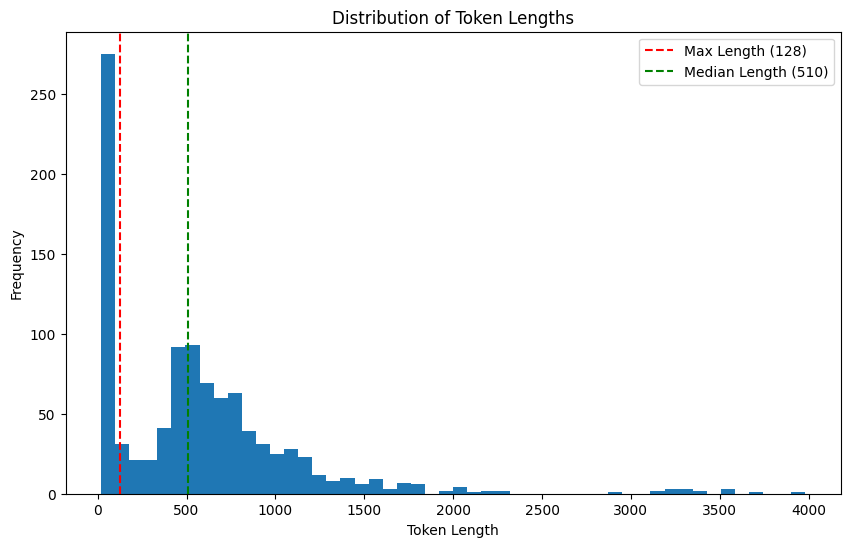

Median token length: 509.5
Mean token length: 582.852
Max token length: 3982
Percentage of samples longer than 128 tokens: 71.40%


In [ ]:
def plot_token_length_histogram(token_lengths):
  plt.figure(figsize=(10, 6))
  plt.hist(token_lengths, bins=50)
  plt.xlabel('Token Length')
  plt.ylabel('Frequency')
  plt.title('Distribution of Token Lengths')
  plt.axvline(x=128, color='r', linestyle='--', label='Max Length (128)')
  plt.axvline(x=np.median(token_lengths), color='g', linestyle='--', label=f'Median Length ({np.median(token_lengths):.0f})')
  plt.legend()
  plt.show()


plot_token_length_histogram(token_lengths)

print(f"Median token length: {np.median(token_lengths)}")
print(f"Mean token length: {np.mean(token_lengths)}")
print(f"Max token length: {np.max(token_lengths)}")
print(f"Percentage of samples longer than 128 tokens: {sum(length > 128 for length in token_lengths) / len(token_lengths) * 100:.2f}%")

 Based on the token length analysis, we are now able to define the maximum sequence length for tokenization. The maintainer of the ElKulako/cryptobert model recommends using a max_length of 128 tokens.

```
MAX_LENGTH = 128

def tokenize_function(text):
    return tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors=None
    )
```

## Label Encoding

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
POSITIVE,7702
NEUTRAL,3898
NEGATIVE,3345


In [ ]:
# Map sentiment to numerical labels
sentiment_map = {
    'NEGATIVE': 0,
    'NEUTRAL': 1,
    'POSITIVE': 2
}

df['label'] = df['sentiment'].map(sentiment_map)
df[['full_text', 'label', 'sentiment']].head()

,full_text,label,sentiment
0,circle to launch global payment and crossborde...,2,POSITIVE
1,coinbase secures more sec document on ethereum...,1,NEUTRAL
2,onyxcoin face uncertainty with sign of potenti...,1,NEUTRAL
3,circle float new payment network for crossbord...,2,POSITIVE
4,maximize your crypto gain with kernel dao ’ s ...,2,POSITIVE


### Label distribution

In [ ]:
df['label'].value_counts()

,count
label,
2,7702
1,3898
0,3345


In [ ]:
df['label'].value_counts(normalize=True)

,proportion
label,
2,0.515356
1,0.260823
0,0.223821


In [ ]:
print("\nLabel distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True))


Label distribution:
label
2    7702
1    3898
0    3345
Name: count, dtype: int64
label
2    0.515356
1    0.260823
0    0.223821
Name: proportion, dtype: float64


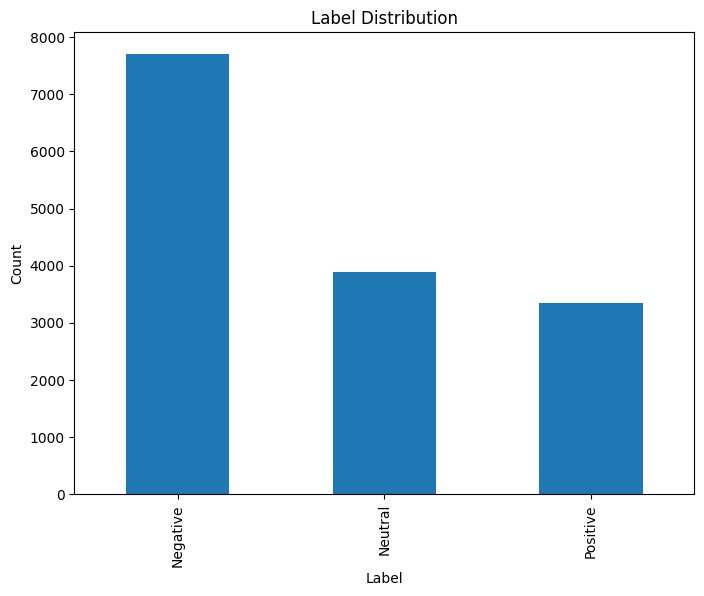

In [ ]:
def plot_label_distribution(df):
  plt.figure(figsize=(8, 6))
  df['label'].value_counts().plot(kind='bar')
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.title('Label Distribution')
  plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
  plt.show()

plot_label_distribution(df)

## Splitting the dataset

Create a dataframe that only consists of the columns/features needed for the task of sentiment analysis.

In [ ]:
data_df = df[['full_text', 'label']].copy()

train_df, temp_df = train_test_split(
    data_df,
    test_size=0.2,
    random_state=42,
    stratify=data_df['label']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

# Output the dataframe of sets + sizes
splits_df = pd.DataFrame({
    'Set': ['Training', 'Validation', 'Testing'],
    'Samples': [len(train_df), len(val_df), len(test_df)]
})
splits_df

,Set,Samples
0,Training,11956
1,Validation,1494
2,Testing,1495


 ## Exporting processed datasets

In [ ]:
if not os.path.exists(EXPORT_DATA_DIR):
    os.makedirs(EXPORT_DATA_DIR)

train_df.to_csv(os.path.join(EXPORT_DATA_DIR, "coindesk_train.csv"), index=False)
val_df.to_csv(os.path.join(EXPORT_DATA_DIR, "coindesk_val.csv"), index=False)
test_df.to_csv(os.path.join(EXPORT_DATA_DIR, "coindesk_test.csv"), index=False)

print(f"Datasets saved to {EXPORT_DATA_DIR}/*")

Datasets saved to /content/drive/My Drive/sentix_nlp/data/preprocessed/*
